# PRefLexOR Inference

In [ ]:
!pip install -U -quiet git+https://github.com/lamm-mit/PRefLexOR.git

In [ ]:
import os

from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer 

from PRefLexOR import *

# Define thinking tokens
think_start = '<|thinking|>'
think_end = '<|/thinking|>'

### Load model 

In [ ]:
model_name='lamm-mit/PRefLexOR_ORPO_DPO_EXO_10242024'

model = AutoModelForCausalLM.from_pretrained(model_name,     
    torch_dtype =torch.bfloat16,
    attn_implementation="flash_attention_2",device_map="auto",trust_remote_code=True,
    )
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,
                                          use_fast=False,
                                         )

### Inference: Conventional

In [ ]:
txt = 'What is the relationship between materials and music? Brief answer.' + f' Use {think_start}.'

output_text, messages = generate_local_model(
    model=model, 
    tokenizer=tokenizer, 
    prompt=txt, 
    system_prompt='',  
    num_return_sequences=1, 
    repetition_penalty=1.0, 
    temperature=0.1, 
    max_new_tokens=2024, 
    messages=[], 
    do_sample=True
)

print(output_text)

#### Extract thinking or other sections from the output

In [ ]:
thinking    = extract_text(output_text, thinking_start=think_start, thinking_end=think_end)[0].strip()
answer_only = extract_text(output_text, thinking_start=think_end, thinking_end="NONE").strip()

In [ ]:
print ("THINKING:\n\n", thinking)

In [ ]:
print ("ANSWER:\n\n", answer_only)

### Inference: Recursive using multi-agent reasoning

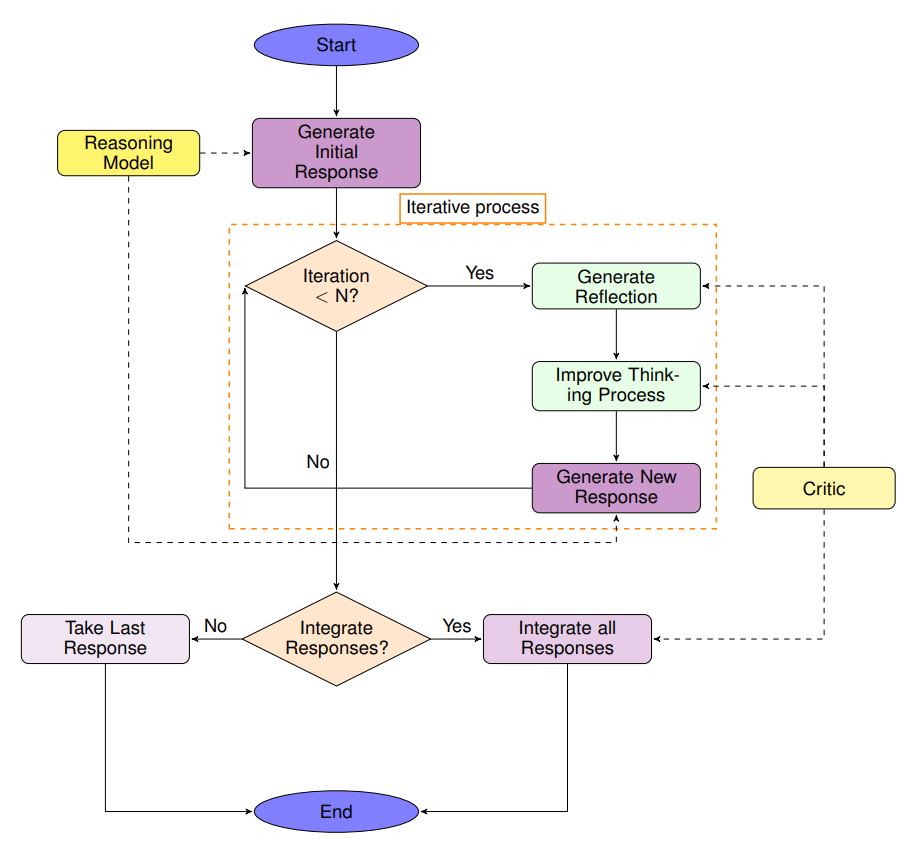

In [ ]:
from PRefLexOR import recursive_response_from_thinking

#### Load second model that will be the critic agent

In [ ]:
model_name_base = "meta-llama/Llama-3.2-3B-Instruct"

critic_model = AutoModelForCausalLM.from_pretrained(
    model_name_base, 
    torch_dtype=torch.bfloat16, 
    attn_implementation="flash_attention_2", 
    device_map="auto", 
    trust_remote_code=True
)

In [ ]:
output_text, output_list, output_text_integrated = recursive_response_from_thinking(
    model=model, 
    tokenizer=tokenizer, 
    model_critic=critic_model, 
    tokenizer_critic=tokenizer,  #same tokenizer in our case
    question="Develop an idea of how graphene can be combined with silk fibers to create a filtration membrane.", 
    N=3, 
    temperature=0.1, 
    temperature_improvement=0.1, 
    system_prompt="You are a helpful assistant.", 
    system_prompt_critic="You carefully improve responses, with attention to detail, and following all directions.",
    verbatim=False,
)

In [ ]:
for i, item in enumerate(output_list):
    print (f"i={i}", 64*"-")
    print (item)

In [ ]:
print ("INTEGRATED RESPONSE:")
print (output_text_integrated)